In [1]:
#!git clone https://github.com/darioka/impactdeal-2022.git
#%cd impactdeal-2022
#!pip install -r requirements.txt
#!pip install .

# Decision Tree

In this notebook, we will apply a [decision tree](https://en.wikipedia.org/wiki/Decision_tree_learning) to the Adult dataset. We will use the `scikit-learn` implementation [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).


## Table of Contents

1. [Train-test split](#Train-test-split)
2. [Training a decision tree Classifier](#Training-a-decision-tree-classifier)
3. [Model evaluation](#Model-evaluation)
4. [Categorical variables](#Categorical-variables)
5. [Conclusions](#Conclusions)

## Train-test split

As we know, in order to be able to estimate a proper generalization performance of a machine learning model, the data is splitted into a training and test set. `sklearn` provides a very useful tool to do it just in one line of code. It is good habit to do the splitting as the first step in a machine learning pipeline.

<div class="alert alert-block alert-info">

The reason is that this will help to avoid possible <b><a href=https://en.wikipedia.org/wiki/Leakage_(machine_learning)>data leakage</a></b>, which is the unintentional use of information extracted from the test set in the training procedure. This happens more often than you may think, for example when inputing missing values or normalizing numerical features.
    
</div>

In [2]:
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


# read the data
X, y = fetch_openml(data_id=1590, return_X_y=True, as_frame=True)

X.shape

(48842, 14)

In [3]:
# the train_test_split function accepts any number of args
# and returns 2*args
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

X_train.shape, X_test.shape

((34189, 14), (14653, 14))

Some comments:
* The split is **random**. However, especially when there is class imbalance, it is desiderable to mantain the same proportion of classes in the targets of the two sets. The `stratify` parameter ensures this.
* Repeated calls to functions that uses randomization yield different results. However, a [`random_state`](https://scikit-learn.org/stable/glossary.html#term-random_state) may be provided to control the behaviour of the random number generation. In particular, setting it to an integer will produce the same results across different calls.

## Training a decision tree classifier

We will now fit a simple decision tree. For simplicity, we will select for the moment just a few columns.

<div class="alert alert-block alert-warning">

Keep in mind that decision trees and many other algorithms cannot deal with missing data. Fortunately for us, numerical columns in the Adult dataset does not contain any missing values. This allow us skip this step and go directly to model building.
    
</div>

In [4]:
my_columns = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

my_X_train = X_train[my_columns]
my_X_test = X_test[my_columns]

my_X_train.shape

(34189, 5)

In [5]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

model.fit(my_X_train, y_train)

DecisionTreeClassifier()

In [6]:
y_train_pred = model.predict(my_X_train)

y_test_pred = model.predict(my_X_test)

y_train_pred

array(['<=50K', '<=50K', '<=50K', ..., '>50K', '<=50K', '>50K'],
      dtype=object)

That's it! We have trained our first machine learning model.

As saw, the `fit` method has been called on the training dataset only. On the contrary, we have used the `predict` method to obtain the predicted classes for both the training and the test data. They will be used in the next section to compute model performances.

Some comments:
* One of the greatest perks of `scikit-learn` is that its iterface (i.e. how we use their objects) is the same for **every** model. All classification and regression model that `scikit-learn` is always used in the same way, namely calling `fit` and `predict` methods.
* `scikit-learn` models accept `pandas` dataframe as inputs, but return `numpy` arrays as output. Just in case, you can find a cheat sheet at [this link](https://assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf).
* The target is an array of strings with values `(<=50K, >50K)`. This is fine for a model like a decision tree, but keep in mind that other binary classification algorithms require the conversion of the target to an array of `(0, 1)`.

## Model evaluation

Now, it is time for scoring.

First of all, let's try to compute [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#:~:text=the%20accuracy%20is%20the%20proportion%20of%20correct%20predictions%20(both%20true%20positives%20and%20true%20negatives)%20among%20the%20total%20number%20of%20cases%20examined), that is the number of times the model has guessed right.

In [7]:
# let's use only the first 5 elements, for simplicity
y_train[:5] == y_train_pred[:5]

38865    True
17212    True
9312     True
15512    True
23576    True
Name: class, dtype: bool

In [8]:
# how many times the model was right?
print(f"{(y_train[:5] == y_train_pred[:5]).sum()} / 5")

5 / 5


In [9]:
# in general
print(f"Train accuracy: {(y_train == y_train_pred).mean()}")

Train accuracy: 0.8832957968937377


Besides accuracy, we know other useful metrics for a binary classification problem, like [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). Also, it would be nice to plot the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). And we want to do it on the test set too. Of course, `scikit-learn` has convient methods to compute all of them.

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay

In [11]:
model_performance = pd.DataFrame([
    [
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)
    ],
    [
        # pos_label needed to specify which is the "positive" class
        precision_score(y_train, y_train_pred, pos_label=">50K"),
        precision_score(y_test, y_test_pred, pos_label=">50K")
    ],
    [
        recall_score(y_train, y_train_pred, pos_label=">50K"),
        recall_score(y_test, y_test_pred, pos_label=">50K")
    ],
], index=["accuracy", "precision", "recall"], columns=["train", "test"])

model_performance

,train,test
accuracy,0.883296,0.820651
precision,0.874665,0.679184
recall,0.597971,0.474615


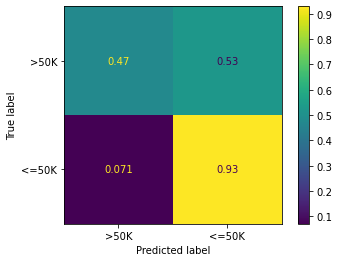

In [12]:
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, normalize="true", labels=[">50K", "<=50K"])

Very interesting!

1. We already have a pretty good accuracy, even with the simplest possible model.
2. Recall is very low, i.e. samples `>50K` are not correctly identified. This can be seen also from the first row of the confusion matrix.
3. All metrics are much smaller on the test set: this may be overfit.

<div class="alert alert-block alert-info">

<b>What to you think?</b>
    
<ol>
  <li> Are those performances (especially recall) good or bad?
  <li> We discussed the relation between the complexity of a model and overfitting. What is <i>complexity</i> for a decision tree?
</ol>
</div>

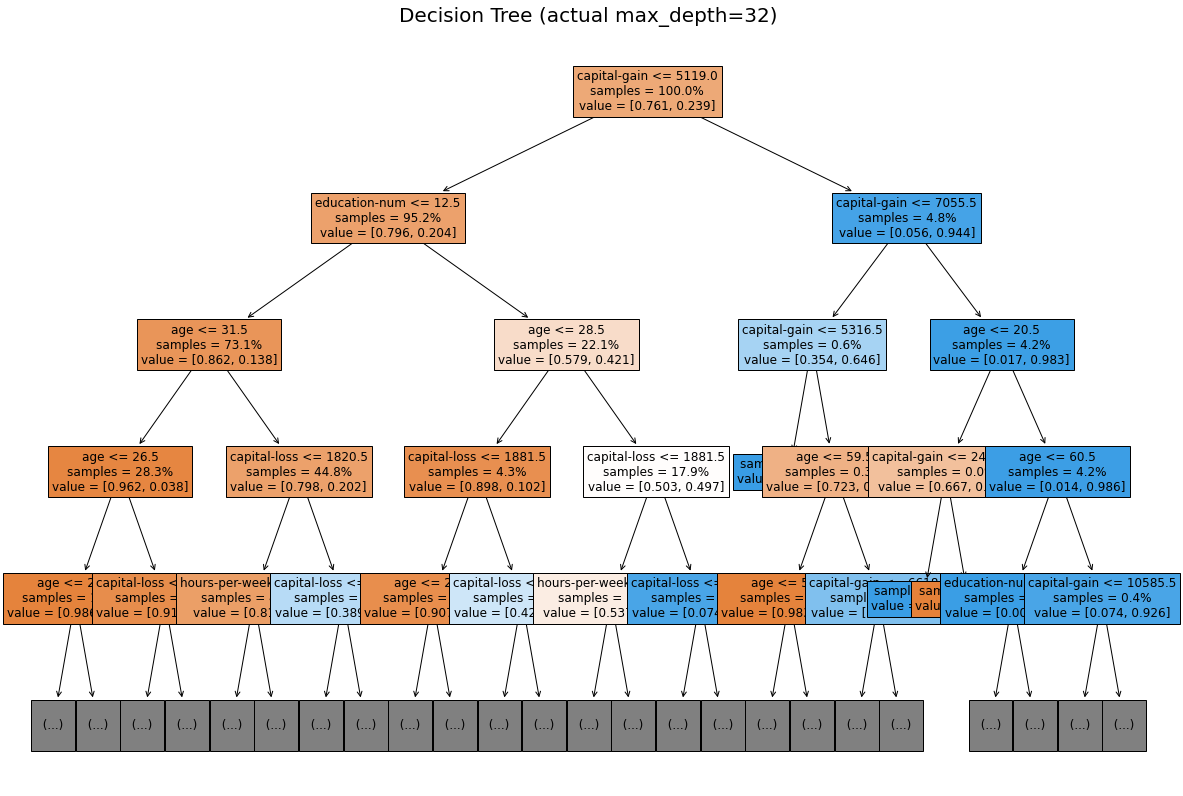

In [13]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


plt.figure(figsize=(20,14))
plot_tree(model, max_depth=4, impurity=False, feature_names=my_columns, fontsize=12, filled=True, proportion=True)
plt.title(f"Decision Tree (actual max_depth={model.tree_.max_depth})", fontsize=20)
plt.show()

The greedy algorithm of the `DecisionTreeClassifier` keeps on splitting until a node has all the same values of the target variable, or when it no longer adds value to the predictions. This is why it reached 32 levels of depth!

This leads to the overfit we observed. We will now show that explicitly, fitting different trees forcing different values of the parameter `max_depth`. When we plot the accuracy vs complexity of the model, we see that the test accuracy reaches a maximum, then start decreasing as `max_depth` increases.

In [14]:
depths = [x for x in range(2, 33)]

train_scores = []
test_scores = []

for d in depths:
    model = DecisionTreeClassifier(max_depth=d)
    print(f"Fitting decision tree with max_depth={d}")
    model.fit(my_X_train, y_train)
    train_scores.append(model.score(my_X_train, y_train))
    test_scores.append(model.score(my_X_test, y_test))

Fitting decision tree with max_depth=2
Fitting decision tree with max_depth=3
Fitting decision tree with max_depth=4
Fitting decision tree with max_depth=5
Fitting decision tree with max_depth=6
Fitting decision tree with max_depth=7
Fitting decision tree with max_depth=8
Fitting decision tree with max_depth=9
Fitting decision tree with max_depth=10
Fitting decision tree with max_depth=11
Fitting decision tree with max_depth=12
Fitting decision tree with max_depth=13
Fitting decision tree with max_depth=14
Fitting decision tree with max_depth=15
Fitting decision tree with max_depth=16
Fitting decision tree with max_depth=17
Fitting decision tree with max_depth=18
Fitting decision tree with max_depth=19
Fitting decision tree with max_depth=20
Fitting decision tree with max_depth=21
Fitting decision tree with max_depth=22
Fitting decision tree with max_depth=23
Fitting decision tree with max_depth=24
Fitting decision tree with max_depth=25
Fitting decision tree with max_depth=26
Fitting 

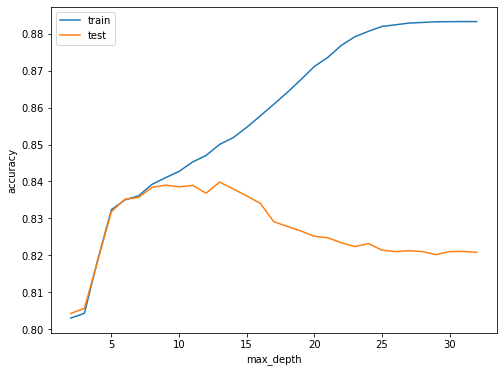

In [15]:
pd.DataFrame(
    [train_scores, test_scores], index=["train", "test"], columns=depths
).transpose().plot(figsize=(8,6))
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.show()

<div class="alert alert-block alert-warning">

<b>Warning!</b>
    
We may be tempted to look at this plot, find the value of depth that give us the best test accuracy, train a model with that value and say that its test accuracy is 83%. In this way we would fall into the trap of <b>data leakage</b>. In fact, we are using the test set to <i>learn</i> something. In other words we are extracting information from the test set (i.e. the best parameter) and reuse it in the training of a new model. If we then evaluate the model on the same test set, we would have an overly optimistic view of its performances.
    
We will talk more about hyperparameter optimization in future modules.
    
</div>

## Categorical variables

We will now add categorical variables to the game... but we have a problem: models work with numbers, not with strings. So we need to convert all categories to numbers.

One obvious to do it, would be to list each unique value of a feature and map them to integers:

```
A  -->  0
B  -->  1
C  -->  2
```

This is what `scikit-learn` [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) does. It works as if it was a model, with a `fit` method that we use to "learn" the mapping from the training data. Then we apply the mapping with a `transform` method, both to the training and test datasets.

Remember that we have missing values too! A common way to deal with missing data is to treat it as another valid category. As in our dataset all missings are encoded with `np.nan`, we will first convert the columns to string so that the `OrdinalEncoder` will see `"null"` values and interpret them as categories.

In [16]:
categorical_columns = ["workclass", "occupation"]

for c in categorical_columns:
    print()
    print(X[c].value_counts())
    print()
    print(f"Missing values present: {X[c].isnull().any()}")
    print("-----------------------------------------")


Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

Missing values present: True
-----------------------------------------

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: occupation, dtype: int64

Missing values present: True
-----------------------------------------


In [17]:
from sklearn.preprocessing import OrdinalEncoder

cat_X_train = X_train[categorical_columns].astype(str)
cat_X_test = X_test[categorical_columns].astype(str)

oe = OrdinalEncoder()

oe.fit(cat_X_train)

# the outputs of sklearn methods are numpy arrays
# but we cat rebuild pandas dataframes
cat_X_train = pd.DataFrame(
    oe.transform(cat_X_train),
    columns = cat_X_train.columns, index=cat_X_train.index)
cat_X_test = pd.DataFrame(
    oe.transform(cat_X_test),
    columns = cat_X_test.columns, index=cat_X_test.index)

cat_X_train.head()

,workclass,occupation
38865,3.0,13.0
17212,8.0,14.0
9312,8.0,14.0
15512,3.0,13.0
23576,3.0,0.0


In [18]:
for column, categories in zip(categorical_columns, oe.categories_):
    print(column)
    for i, cat in enumerate(categories):
        print(f"{i}  <-->  {cat}")
    print("-----------------------------------")

workclass
0  <-->  Federal-gov
1  <-->  Local-gov
2  <-->  Never-worked
3  <-->  Private
4  <-->  Self-emp-inc
5  <-->  Self-emp-not-inc
6  <-->  State-gov
7  <-->  Without-pay
8  <-->  nan
-----------------------------------
occupation
0  <-->  Adm-clerical
1  <-->  Armed-Forces
2  <-->  Craft-repair
3  <-->  Exec-managerial
4  <-->  Farming-fishing
5  <-->  Handlers-cleaners
6  <-->  Machine-op-inspct
7  <-->  Other-service
8  <-->  Priv-house-serv
9  <-->  Prof-specialty
10  <-->  Protective-serv
11  <-->  Sales
12  <-->  Tech-support
13  <-->  Transport-moving
14  <-->  nan
-----------------------------------


In the last cell, we have used the attributes `categories_` of `OrdinalEncoder` to show the mapping between classes and mapped integers.

<div class="alert alert-block alert-warning">

An important thing to observe here is that this encoding imposes a notion of order between categories. Actually this makes no sense for variables that are not inherently ordered. For example,
    
    Craft-repair < Tech-support

has no meaning. In principle, by doing this we would be providing misleading information to a downstream model. Its impact however really depends on the choice of the model. For example, decision trees are not impacted, while logistic regression is.

</div>

Now, we can concatenate the numerical part of the dataset with the categorical part and finally train a new model.

In [19]:
my_X_train = pd.concat([my_X_train, cat_X_train], axis=1)
my_X_test = pd.concat([my_X_test, cat_X_test], axis=1)

my_X_test.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass,occupation
39432,40.0,11.0,2829.0,0.0,40.0,3.0,13.0
25976,52.0,10.0,0.0,0.0,50.0,5.0,11.0
3591,49.0,7.0,0.0,0.0,40.0,3.0,6.0
25158,27.0,9.0,0.0,0.0,40.0,3.0,0.0
6288,45.0,3.0,0.0,0.0,40.0,3.0,7.0


              precision    recall  f1-score   support

        >50K       0.74      0.49      0.59      3506
       <=50K       0.86      0.95      0.90     11147

    accuracy                           0.84     14653
   macro avg       0.80      0.72      0.74     14653
weighted avg       0.83      0.84      0.82     14653



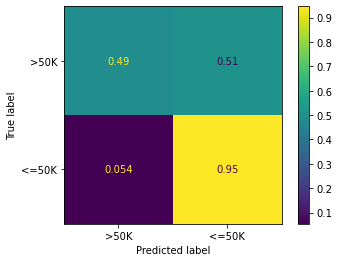

In [20]:
from sklearn.metrics import classification_report

model = DecisionTreeClassifier(max_depth=10)
model.fit(my_X_train, y_train)

print(classification_report(y_test, model.predict(my_X_test), labels=[">50K", "<=50K"]))

_ = ConfusionMatrixDisplay.from_estimator(model, my_X_test, y_test, normalize="true", labels=[">50K", "<=50K"])

## Conclusions

In this notebook we have used a decision tree model to tackle a binary classification problem. We have learned:

* How to split the data in training and test datasets,
* How to fit a `DecisionTreeClassifier`,
* How to evaluate a model in a binary classification setup, computing accuracy, precision, recall and confusion matrix,
* What complexity means for a decision tree and how it affects the generalization power of the model,
* How to handle categorical variables with an `OrdinalEncoder`.

There several reasons why we chose to focus first on decision trees.
1. Thanks to their "tree" structure, they are easy to visualize and interpret.
2. They are robust to outliers.
3. Categorical variables can be handled in a simple way.